In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import glob
import os

import phenom

import tempfile
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.use("agg")

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [166]:
import wispy.waveutils
import wispy.model_utils
import wispy.callbacks

In [3]:
def load_training_data(root_dir):
    data = {}
    data['times']                  = np.load(os.path.join(f'{root_dir}', 'times.npy'))
    data['data_processing_params'] = np.load(os.path.join(f'{root_dir}', 'data_processing_params.npz'))
    data['phase']                  = np.load(os.path.join(f'{root_dir}', 'phase.npy'))
    data['mass_ratios']            = np.load(os.path.join(f'{root_dir}', 'mass-ratios.npy'))
    data['approximants']           = np.load(os.path.join(f'{root_dir}', 'approximants.npy'))
    data['amplitude']              = np.load(os.path.join(f'{root_dir}', 'amplitude.npy'))
    
    num_waveforms = data['amplitude'].shape[0]
    indicies = np.arange(num_waveforms)
    
    data['unique_approximants'] = np.unique(data['approximants'])
    
    # mask is a dictionary with keys the same as the approximants
    # this contains the indicies of each approximant
    data['mask'] = {}
    for k in data['unique_approximants']:
        data['mask'].update({k:indicies[k == data['approximants']]})
    
    return data

In [4]:

# "/Users/spx8sk/work/data/wispy-data/eob_phend_nr/training_data"

# "/Users/spx8sk/work/data/wispy-data/add_phenC/training_data"

In [5]:
# training_data = load_training_data(root_dir="/Users/spx8sk/work/data/wispy-data/eob_phend_nr/training_data")
training_data = load_training_data(root_dir="/Users/spx8sk/work/data/wispy-data/add_phenC/training_data")

In [6]:
# validation_data = load_training_data(root_dir="/Users/spx8sk/work/data/wispy-data/eob_phend_nr/validation_data")
validation_data = load_training_data(root_dir="/Users/spx8sk/work/data/wispy-data/add_phenC/validation_data")

In [7]:
list(training_data)

['times',
 'data_processing_params',
 'phase',
 'mass_ratios',
 'approximants',
 'amplitude',
 'unique_approximants',
 'mask']

In [8]:
training_data['mask']

{'IMRPhenomC': array([200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
        213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
        226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
        239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
        252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,
        265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277,
        278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290,
        291, 292, 293, 294, 295, 296, 297, 298, 299]),
 'IMRPhenomD': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89

In [9]:
def get_training_data(data, data_name):
    x_tmp = {}
    y_tmp = {}
    for i, approx in enumerate(data['unique_approximants']):
        print(f"working {approx}")
        mask = data['mask'][approx]
        num_cases = len(mask)
        qs = data['mass_ratios'][mask]
        names = np.repeat(i, num_cases)
        x_tmp[approx] = np.transpose((names, qs))
        y_tmp[approx] = data[data_name][mask]
        
    x = np.row_stack([x_tmp[approx] for approx in x_tmp.keys()])
    y = np.row_stack([y_tmp[approx] for approx in y_tmp.keys()])
    
    return x, y

In [10]:
def build_decoder(input_shape, output_shape, units, acts, skip=False):
    # build the decoder
    input_layer = keras.Input(shape=(input_shape,))
    for i, (unit, act) in enumerate(zip(units, acts)):
        if i == 0:
            x = layers.Dense(unit, activation=act)(input_layer)
        else:
            x = layers.Dense(unit, activation=act)(x)
            
    if skip:
        x = layers.Dense(input_shape, activation='linear')(x)
        addition = tf.keras.layers.Add()([input_layer, x])
        x = tf.keras.layers.ReLU()(addition)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
            
    timeseries_output = layers.Dense(output_shape, activation="linear")(x)
    decoder_model = keras.Model(input_layer, timeseries_output)
#     print("=" * 20)
#     print("decoder summary")
#     print("=" * 20)
#     decoder_model.summary()

    return decoder_model

In [11]:
def setup_modelling(data_name, training_data, validation_data, skip=False):
    print(f"data_name: {data_name}")
    x, y = get_training_data(training_data, data_name)
    xval, yval = get_training_data(validation_data, data_name)
    
    NR_NUM = float(np.where(training_data["unique_approximants"]=="NR")[0][0])
    print(NR_NUM)

    sample_weight = np.ones(len(y),)
    sample_weight[x[:,0]==NR_NUM] = 10
    
    output_shape = y.shape[1]
    input_shape = x.shape[1]
    

    units = [16, 128, 512]
    acts = ['relu', 'relu', 'relu']

    # units = [16, 128]
    # acts = ['relu', 'relu']

    # units = [16, 128, 128, 128]
    # acts = ['relu', 'relu', 'relu', 'relu']

    print(f"input_shape = {input_shape}")
    print(f"output_shape = {output_shape}")
    
    model = build_decoder(input_shape, output_shape, units, acts, skip=skip)
    
    return model, dict(x=x, y=y, xval=xval, yval=yval, sample_weight=sample_weight)

In [12]:
times = training_data['times']

In [105]:
model_amp, amplitude_training_data = setup_modelling("amplitude", training_data, validation_data, skip=False)

data_name: amplitude
working IMRPhenomC
working IMRPhenomD
working NR
working SEOBNRv4_opt
working IMRPhenomC
working IMRPhenomD
working SEOBNRv4_opt
2.0
input_shape = 2
output_shape = 4150


In [106]:
amplitude_training_data['x'].shape

(305, 2)

In [107]:
amplitude_training_data['y'].shape

(305, 4150)

# just testing so lets just take the first class

In [181]:
# x = amplitude_training_data['x'][:100][:,1][:,np.newaxis]
# y = amplitude_training_data['y'][:100][:,:1024]
# xval = amplitude_training_data['xval'][:100][:,1][:,np.newaxis]
# yval = amplitude_training_data['yval'][:100][:,:1024]

x = amplitude_training_data['x'][:10][:,1][:,np.newaxis]
y = amplitude_training_data['y'][:10][:,:1024]
xval = amplitude_training_data['xval'][:10][:,1][:,np.newaxis]
yval = amplitude_training_data['yval'][:10][:,:1024]

times = training_data['times'][:1024]

In [182]:
x[0]

array([1.])

In [183]:
print(x.shape)
print(y.shape)
print(xval.shape)
print(yval.shape)

(10, 1)
(10, 1024)
(10, 1)
(10, 1024)


Text(0.5, 1.0, 'q = 1.0')

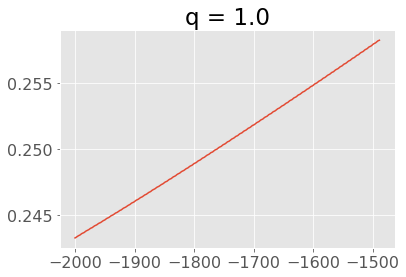

In [184]:
plt.figure()
plt.plot(times, y[0])
plt.title(f"q = {x[0,0]}")

In [185]:
64*128

8192

In [186]:
def create_model(input_shape, output_shape):
    input_layer = tf.keras.layers.Input(shape=(input_shape,))
    
    x = tf.keras.layers.Dense(64*128)(input_layer)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Reshape((64, 1, 128))(x)
    
#     x = tf.keras.layers.Conv2DTranspose(128, kernel_size=(18, 1), strides=(1,1), padding='same')(x)
#     x = tf.keras.layers.Activation('relu')(x)
    
#     x = tf.keras.layers.Conv2DTranspose(64, kernel_size=(18, 1), strides=(1,1), padding='same')(x)
#     x = tf.keras.layers.Activation('relu')(x)
    
#     x = tf.keras.layers.Conv2DTranspose(32, kernel_size=(18, 1), strides=(1,1), padding='same')(x)
#     x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2DTranspose(1, kernel_size=(18, 1), strides=(1,1), padding='same')(x)
    x = tf.keras.layers.Activation('linear')(x)
    
    output_layer = tf.keras.layers.Reshape((output_shape,))(x)
    
    model = tf.keras.models.Model(input_layer, output_layer)
    
    return model

In [187]:
y.shape[1]

1024

In [188]:
model = create_model(input_shape=x.shape[1], output_shape=y.shape[1])

ValueError: total size of new array must be unchanged, input_shape = [64, 1, 1], output_shape = [1024]

In [189]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D, BatchNormalization
from tensorflow.keras.layers import Conv2D,Conv2DTranspose
from tensorflow.keras.layers import Activation, LeakyReLU
from tensorflow.keras.layers import Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Concatenate
def define_generator(latent_dim):
    # image input
    x = Input(shape=(latent_dim,))

    n_nodes = 256 * 128
    merge = Dense(n_nodes)(x)
    merge = Activation('relu')(merge)

    # Add dimension as there's no 1DTranspose
    merge = Reshape((64,1,512))(merge)
    # upsample
#     gen = Conv2DTranspose(512, kernel_size=(18,1), strides=(1,1), padding='same')(merge)
#     gen = Activation('relu')(gen)
#     gen = BatchNormalization()(gen)
    gen = Conv2DTranspose(256, kernel_size=(18,1), strides=(2,1), padding='same')(merge)
    gen = Activation('relu')(gen)
    gen = Conv2DTranspose(128, kernel_size=(18,1), strides=(2,1), padding='same')(gen)
    gen = Activation('relu')(gen)
    gen = Conv2DTranspose(64, kernel_size=(18,1), strides=(2,1), padding='same')(gen)
    gen = Activation('relu')(gen)
    gen = Conv2DTranspose(1, kernel_size=(18,1), strides=(2,1), padding='same')(gen)
    gen = Activation('linear')(gen)
   # output
    out_layer = Reshape((1024,))(gen)
    # define model
    model = Model([x], [out_layer])
    model.summary()
    return model

In [190]:
model = define_generator(1)

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_44 (Dense)             (None, 32768)             65536     
_________________________________________________________________
activation_112 (Activation)  (None, 32768)             0         
_________________________________________________________________
reshape_46 (Reshape)         (None, 64, 1, 512)        0         
_________________________________________________________________
conv2d_transpose_89 (Conv2DT (None, 128, 1, 256)       2359552   
_________________________________________________________________
activation_113 (Activation)  (None, 128, 1, 256)       0         
_________________________________________________________________
conv2d_transpose_90 (Conv2DT (None, 256, 1, 128)       589

In [191]:
# tf.keras.utils.plot_model(model)

In [192]:
model.predict([1]).shape

2021-04-16 17:21:52,765 - WARNING - 5 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x162c029e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


(1, 1024)

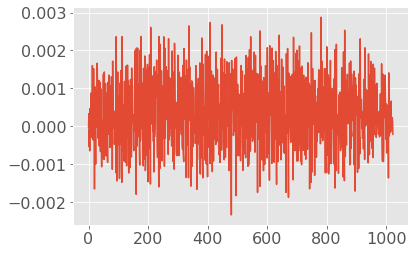

In [193]:
plt.figure()
plt.plot(model.predict([1])[0])

In [194]:
def initial_fit(model, x, y, validation_data=None, epochs=10000, batch_size=100, validation_freq=100, lr=None, sample_weight=None):
        
    loss = 'mae'
    metrics = ['mse']

    if lr == None:
#         boundaries = [5000, 5100]
#         values = [1e-3, 1e-4, 1e-5]
        boundaries = [500, 600]
        values = [1e-3, 1e-4, 1e-5]
        learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
            boundaries, values)
        opt = tf.keras.optimizers.Adam(learning_rate_fn)
    else:
        opt = tf.keras.optimizers.Adam(lr)

    model.compile(optimizer=opt, loss=loss, metrics=metrics)

    callbacks=[]
    tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
    callbacks.append(tqdm_callback)
    
#     threshold_callback = wispy.callbacks.ThresholdCallback(1e-7)
#     callbacks.append(threshold_callback)

    history = model.fit(
        x=x,
        y=y,
        epochs=epochs,
        callbacks=callbacks,
        verbose=0,
        batch_size=batch_size,
        validation_data=validation_data,
        validation_freq=validation_freq,
        sample_weight=sample_weight
    )

    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mse'], label='mse')
    plt.yscale('log')
    plt.legend()

    if validation_data is not None:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['val_mse'], label='val_mse')

        plt.yscale('log')
        plt.legend()
    
    return history, model

Training:   0%|           0/1000 ETA: ?s,  ?epochs/s

CPU times: user 7min 43s, sys: 48.9 s, total: 8min 32s
Wall time: 1min 38s


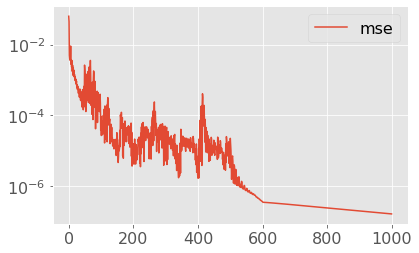

In [195]:
%%time
history, model = initial_fit(
    model,
    x=x,
    y=y,
#     validation_data=(xval, yval),
    validation_data=None,
    epochs=1000,
    batch_size=10,
    validation_freq=1,
    lr=None,
    sample_weight=None
)

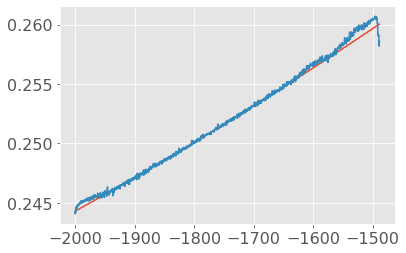

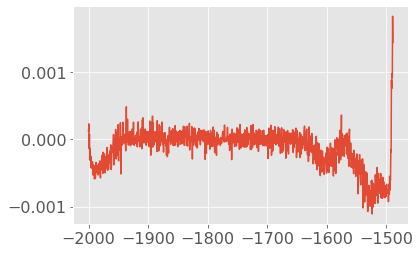

In [207]:
index = 3

plt.figure()
plt.plot(times, y[index])
plt.plot(times, model.predict(x)[index])
# plt.xlim(-2000, -1900)

plt.figure()
plt.plot(times, y[index]-model.predict(x)[index])